**Coursebook: Generate and Run Airflow Script**

- Part of Data Engineering Airflow Specialization
- Course Length: 1 Hours
- Last Updated: May 2024

---


- Developed by [Algoritma](https://algorit.ma/)'s product division and instructors team

# Background
 
The coursebook is part of the **Data Engineering Airflow Specialization** prepared by Algoritma. The coursebook is intended for a restricted audience only, i.e. the individuals and organizations having received this coursebook directly from the training organization. It may not be reproduced, distributed, translated or adapted in any form outside these individuals and organizations without permission.

Algoritma is a data science education center based in Jakarta. We organize workshops and training programs to help working professionals and students gain mastery in various data science sub-fields: data visualization, machine learning, data modeling, statistical inference etc.

## Training Objectives

This coursebook is intended to perform how to manage, prepare python script to run airflow and how to monitor the pipeline in Airflow webserver.

This coursebook focused on:

- Docker airflow project
- Create DAG Script
- Run Scheduled DAG
- Monitoring Task in Airflow Webserver.



# How to Generate and Run Script in Airflow


Before discussing running the Airflow project, let's ensure that the directory structure you've created is as follows:

## Docker Airflow Project Directory Structure

This Markdown document outlines a suggested directory structure for organizing an Apache Airflow project with Docker.

### 📁 data_engineering_airflow

- 📁 dags
  - 📄 .env
    - (Environment file containing YOUTUBE_API_KEY)
  - 📄 service_account_key.json
    - (Service account key file for YouTube API)
  - 📄 categories.json
    - (JSON file containing YouTube video categories)
  - 📄 tmp_file.json
    - (Temporary JSON file)
  - 📄 tmp_file_processed.json
    - (Processed JSON file)
  - 📚 **trending_youtube_dag_sqlite.py**
    - (DAG definition for processing trending YouTube data)

- 📁 db
  - (Directory for Airflow database)

- 📁 logs
  - (Directory for Airflow logs)

- 📁 plugins
  - (Directory for Airflow plugins)


- 📄 .env
  - (Environment file containing AIRFLOW_UID=50000)

- 📚 **01_fetch_data_api.ipynb**
- 📚 **02_airflow_introduction.ipynb**
- 📚 **03_connect_db_to_airflow.ipynb**
- 📚 **04_generate_and_run_script.ipynb**

- 📄 docker-compose.yaml
  - (Docker Compose file for defining Airflow services)

- 📄 Dockerfile
  - (Dockerfile for customizing Airflow image, if needed for install requirements.txt)

- 📄 README.md
  - (Project documentation)

- 📄 requirements.txt
  - (Python dependencies for the project)

## Create DAG Script

After you finised three module before, you're ready to run your own DAG. There are some steps that you need to do before run docker Airflow

1. **Create DAG File:**
   - Within your project, create a new file with the extension `.py`. For example, `my_dag.py`.

2. **Copy Existing Code:**
   - Copy the code you already have from module 03 into the new file.

3. **Save File:**
   - Save the file by pressing `Ctrl + S` (on Windows/Linux) or `Cmd + S` (on macOS), or through the "File" > "Save" menu.

Edit this markdown as a full version of our DAG file.

<!-- 
from airflow.decorators import dag, task
from googleapiclient.discovery import build
import json
from datetime import datetime, timedelta, timezone
import isodate
import os
import pandas as pd
import sqlite3
from dotenv import load_dotenv

default_args = {
    'owner': 'airflow',
    'retries': 3,
    'retry_delay': timedelta(minutes=5)
}

@dag(dag_id='trending_youtube_dag_sqlite',
    default_args=default_args,
    description='A pipeline to fetch trending YouTube videos into SQLite db',
    start_date=datetime(2023, 5, 7, tzinfo=timezone(timedelta(hours=7))),
    schedule_interval='0 10 * * *',
    catchup=False)
def trending_youtube_dag():
    @task()
    def fetch_trending_videos(region_code: str, max_results: int, target_file_path: str):
        """Fetches trending videos from YouTube for a specific region.

        Args:
            region_code: A string representing the ISO 3166-1 alpha-2 country code for the desired region.
            max_results: An integer representing the maximum number of results to fetch.
            target_file_path: A string representing the path to the file to be written.
        """
        
        # Load API key from .env file
        load_dotenv("/opt/airflow/dags/.env")
        api_key = os.environ.get("YOUTUBE_API_KEY")

        # Create YouTube API client
        youtube = build("youtube", "v3", developerKey=api_key)

        # Fetch videos until max_results is reached or there are no more results
        videos_list = []
        next_page_token = ""
        while len(videos_list) < max_results and next_page_token is not None:
            # Make API request for videos
            request = youtube.videos().list(
                part="snippet,contentDetails,statistics",
                chart="mostPopular",
                regionCode=region_code,
                maxResults=50,
                pageToken=next_page_token,
            )
            response = request.execute()

            # Extract videos from response
            videos = response.get("items", [])

            # Update next_page_token for the next API request
            next_page_token = response.get("nextPageToken", None)
            
            # Extract relevant video details and append to list
            infos = {'snippet':['title', 'publishedAt', 'channelId', 'channelTitle',
                                'description', 'tags', 'thumbnails', 'categoryId', 'defaultAudioLanguage'],
                        'contentDetails':['duration', 'caption'],
                        'statistics':['viewCount', 'likeCount', 'commentCount']}
            now = datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
            for video in videos:
                video_details = {
                    'videoId': video["id"],
                    'trendingAt': now
                }
                
                for k in infos.keys():
                    for info in infos[k]:
                        # use try-except to handle missing info
                        try:
                            video_details[info] = video[k][info]
                        except KeyError:
                            video_details[info] = None
                            
                videos_list.append(video_details)

        # Write fetched videos data to a json file
        with open(target_file_path, "w") as f:
            json.dump(videos_list, f)
    
    @task()
    def data_processing(source_file_path: str, target_file_path: str):
        """Processes the raw data fetched from YouTube.
        
        Args:
            source_file_path: A string representing the path to the file to be processed.
            target_file_path: A string representing the path to the file to be written.
        """
        # Load the fetched videos data from the json file
        with open(source_file_path, 'r') as f:
            videos_list = json.load(f)
        
        # Load the categories dictionary from the json file
        with open('/opt/airflow/dags/categories.json', 'r') as f:
            categories = json.load(f)
        
        # Process the fetched videos data
        for video in videos_list:
            # Convert ISO 8601 duration to seconds
            video['durationSec'] = int(isodate.parse_duration(video['duration']).total_seconds()) if video['duration'] is not None else None
            del video['duration']
            
            # Convert tags list to string
            video['tags'] = ', '.join(video['tags']) if video['tags'] is not None else None
            
            # Convert categoryId to category based on categories dictionary
            video['category'] = categories.get(video['categoryId'], None) if video['categoryId'] is not None else None
            del video['categoryId']

            # Parse the thumbnail url
            video['thumbnailUrl'] = video['thumbnails'].get('standard', {}).get('url', None) if video['thumbnails'] is not None else None
            del video['thumbnails']
            
            # Convert viewCount, likeCount, and commentCount to integer
            video['viewCount'] = int(video['viewCount']) if video['viewCount'] is not None else None
            video['likeCount'] = int(video['likeCount']) if video['likeCount'] is not None else None
            video['commentCount'] = int(video['commentCount']) if video['commentCount'] is not None else None
            
            # Convert caption to boolean
            video['caption'] = True if video['caption'] == 'true' else False if video['caption'] == 'false' else None
        
        # Save the processed videos data to a new file
        with open(target_file_path, "w") as f:
            json.dump(videos_list, f)
            
    @task()
    def load_to_sqlite(source_file_path: str, table_name: str):
        """
        Loads the processed data to SQLite.
        
        Args:
            source_file_path: A string representing the path to the file to be loaded.
            table_name: A string representing the name of the table to load the data to.
        """
        
        # Load the data from the json file to sqlite
        df = pd.read_json(source_file_path)
        database = "/opt/airflow/db/airflow.db"
        conn = sqlite3.connect(database)
        
        # Append the DataFrame to the existing table if it exists, otherwise create a new table
        df.to_sql(name=table_name, con=conn, if_exists='append', index=False)
        
        conn.close()
    
        # Log the job results
        print("Done Created DB")
    
    file_path = '/opt/airflow/dags/tmp_file.json'
    fetch_trending_videos_task = fetch_trending_videos(region_code='ID', max_results=200, target_file_path=file_path)
    processed_file_path = '/opt/airflow/dags/tmp_file_processed.json'
    data_processing_task = data_processing(source_file_path=file_path, target_file_path=processed_file_path)
    load_to_sqlite_task = load_to_sqlite(source_file_path=processed_file_path, table_name='trending_videos')
    
    fetch_trending_videos_task >> data_processing_task >> load_to_sqlite_task
    
dag = trending_youtube_dag()
---> 


## Run Scheduled DAG & Monitoring The DAG Through Airflow Webserver UI

To run Airflow in Docker, you will need to have Docker and Docker Compose installed beforehand. To do so, simply download and install Docker Desktop in your local machine depending on your OS via the [official Docker website](https://docs.docker.com/get-docker/). 

Once you have installed Docker Desktop, ensure that you have Docker Compose with v1.27.0 or newer installed by running this command

```
$ docker compose version
Docker Compose version v2.7.0
```

Afterwards, you need to download `docker-compose.yaml` by downloading [here](https://github.com/finesaaa/data-engineering-airflow/blob/main/docker-compose.yaml). It is modified version from [here](https://airflow.apache.org/docs/apache-airflow/2.6.0/docker-compose.yaml). If you open the docker.compose.yaml file, you will see that it defines many services and composes them in a proper way. Now we need to initialize the environment.

```
docker compose up -d
```

It will create an account with username `airflow` and password `airflow`. Run Airflow by using `docker compose up`, then navigate to `localhost:8080` and login using the credentials.

Now that we have created the DAG, it’s time to check the Airflow Webserver UI to see if the DAG has been registered successfully. I assume that you have followed the instructions in the earlier section to install and run Airflow using Docker. First open Docker Desktop and and ensure that the containers (except for airflow-init-1) under `data_engineering_airflow` are running. You can verify this by checking the container status, as shown in the screenshot below.

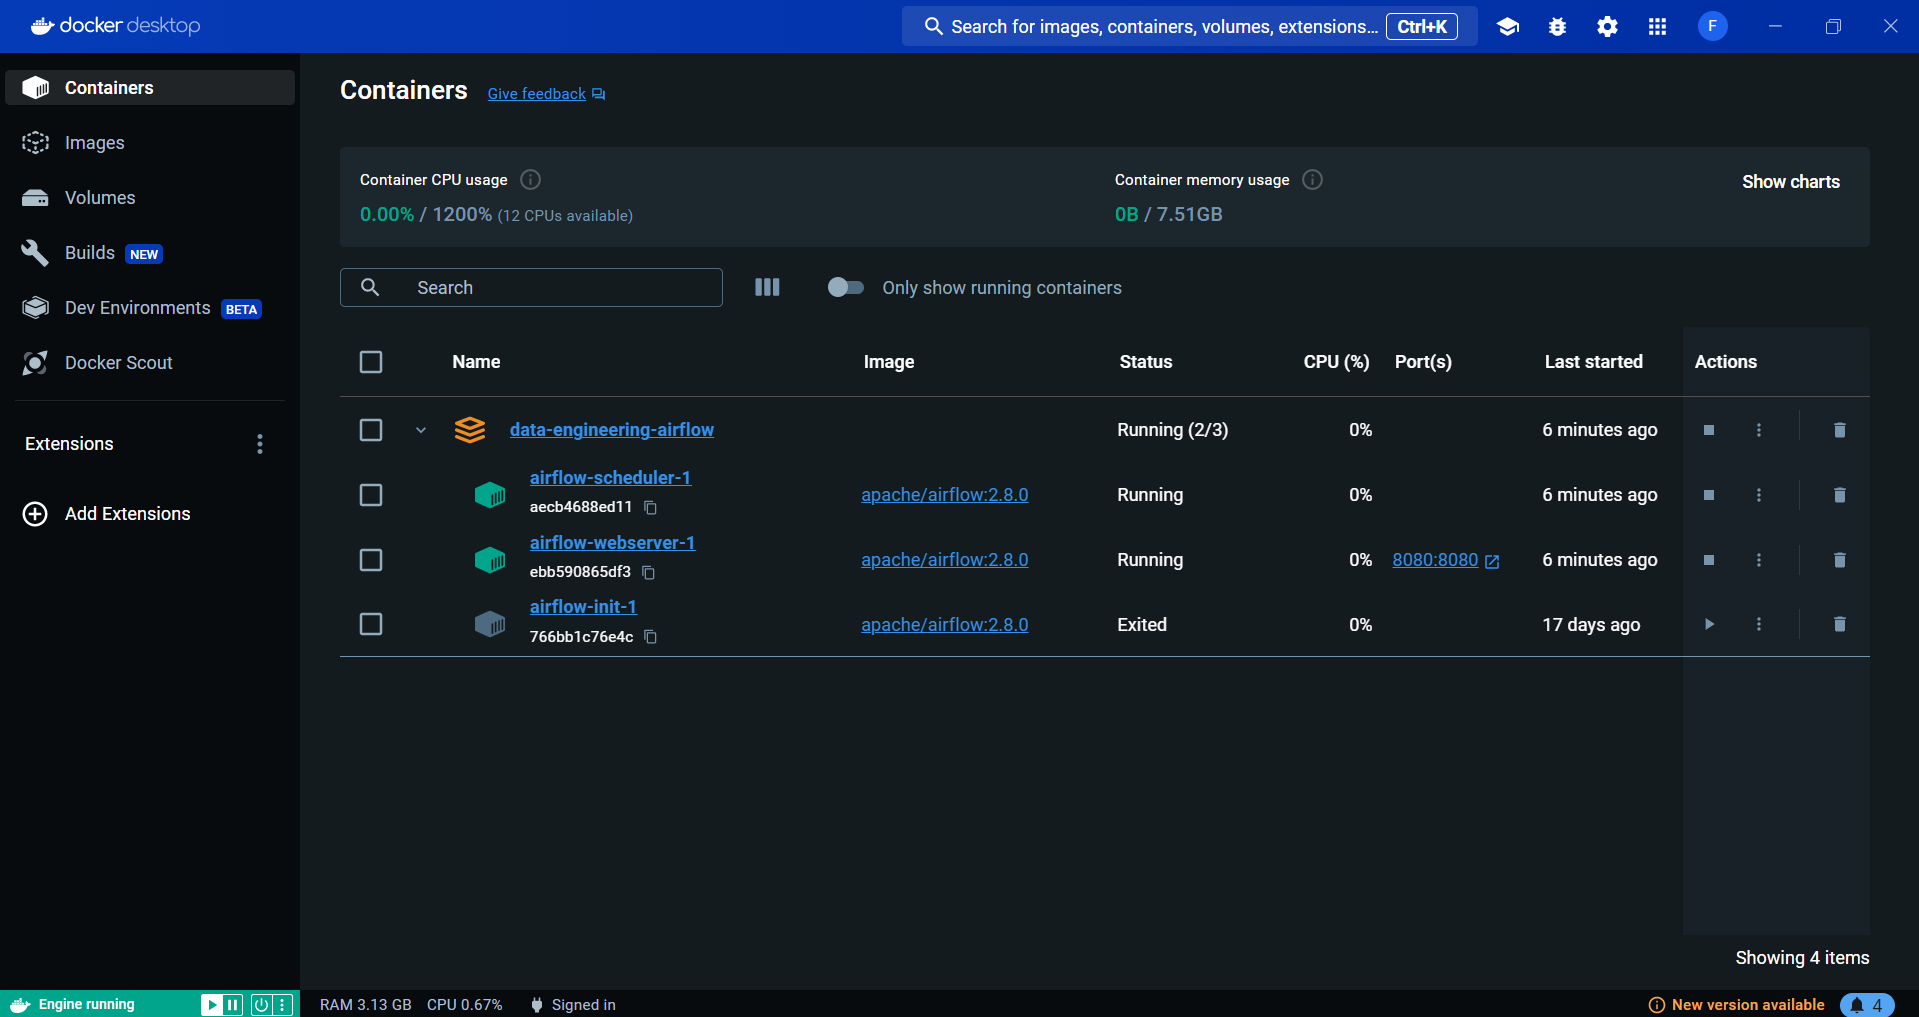

As seen from the last screenshot, the port for `airflow-webserver-1` is shown as 8080:8080. This means port 8080 on the host machine is mapped to port 8080 on the container. Now open your browser and go to http://localhost:8080 to access the Airflow Webserver UI. 

Enter your username and password, which by default are both `airflow`. After logging in, you should be able to see the list of DAGs registered in Airflow. Search for the DAG that we have created earlier (`trending_youtube_dag_sqlite`) and click on it to see the details.

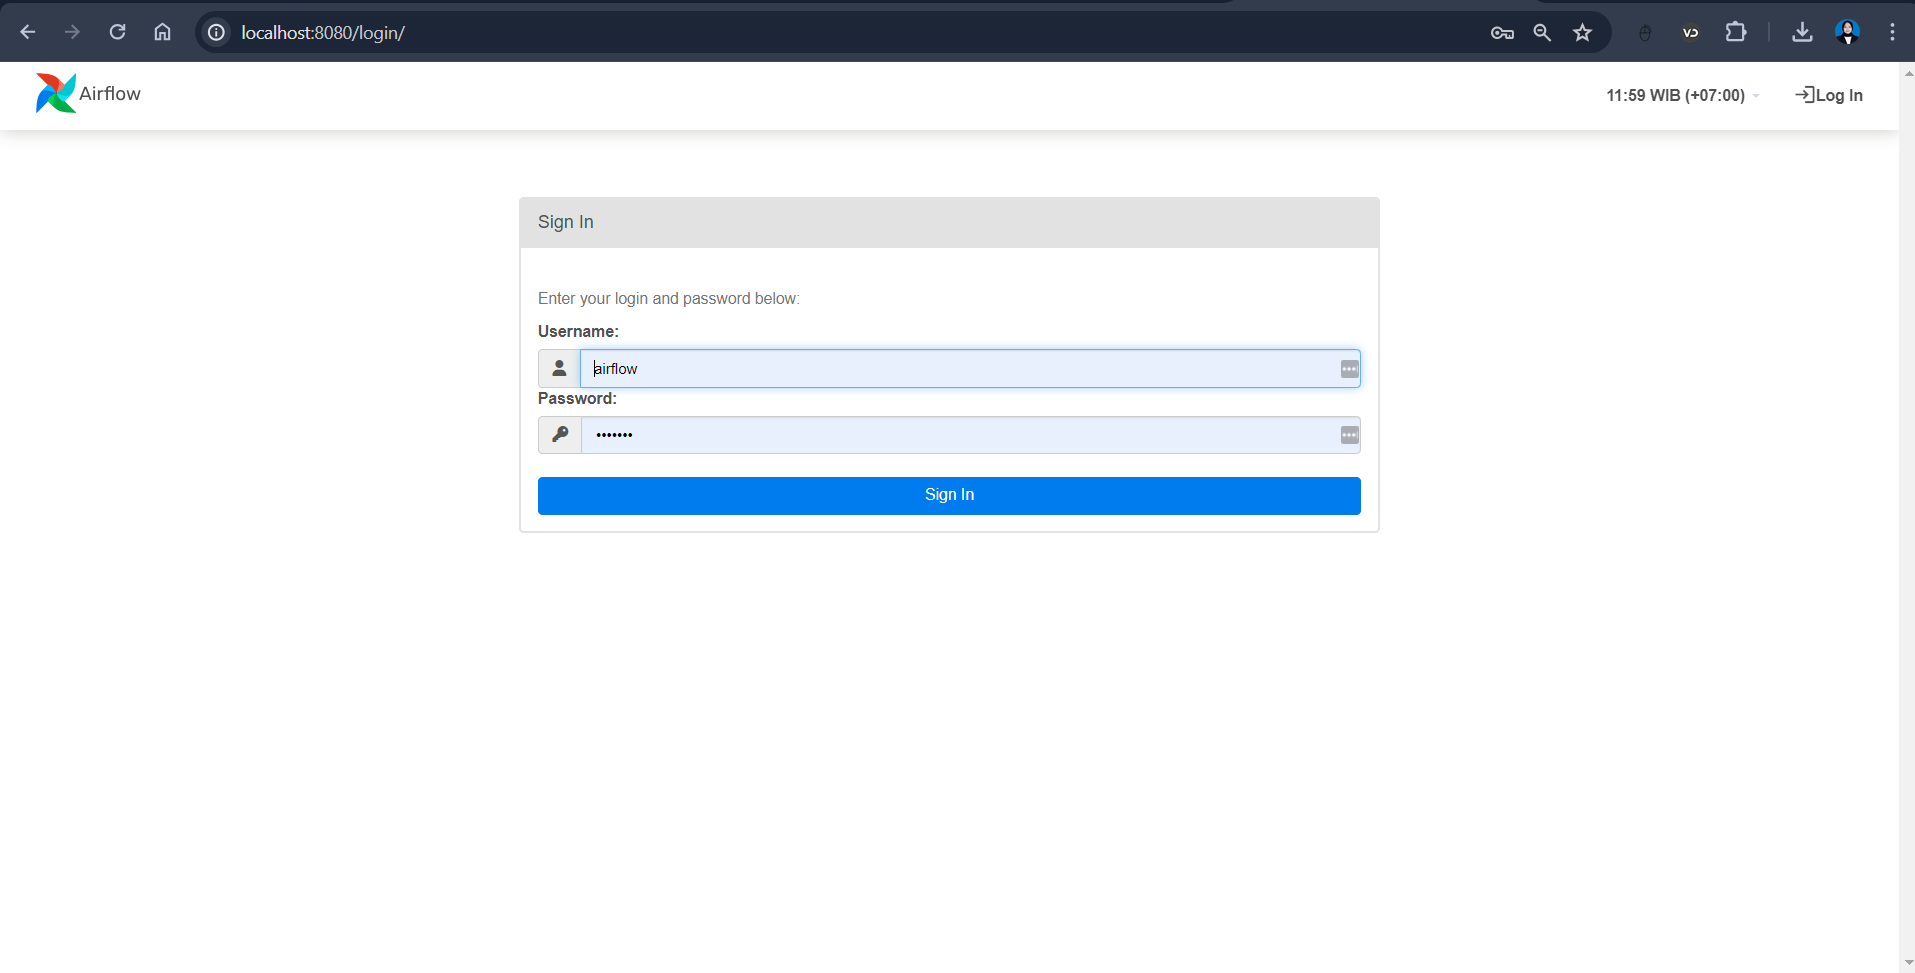

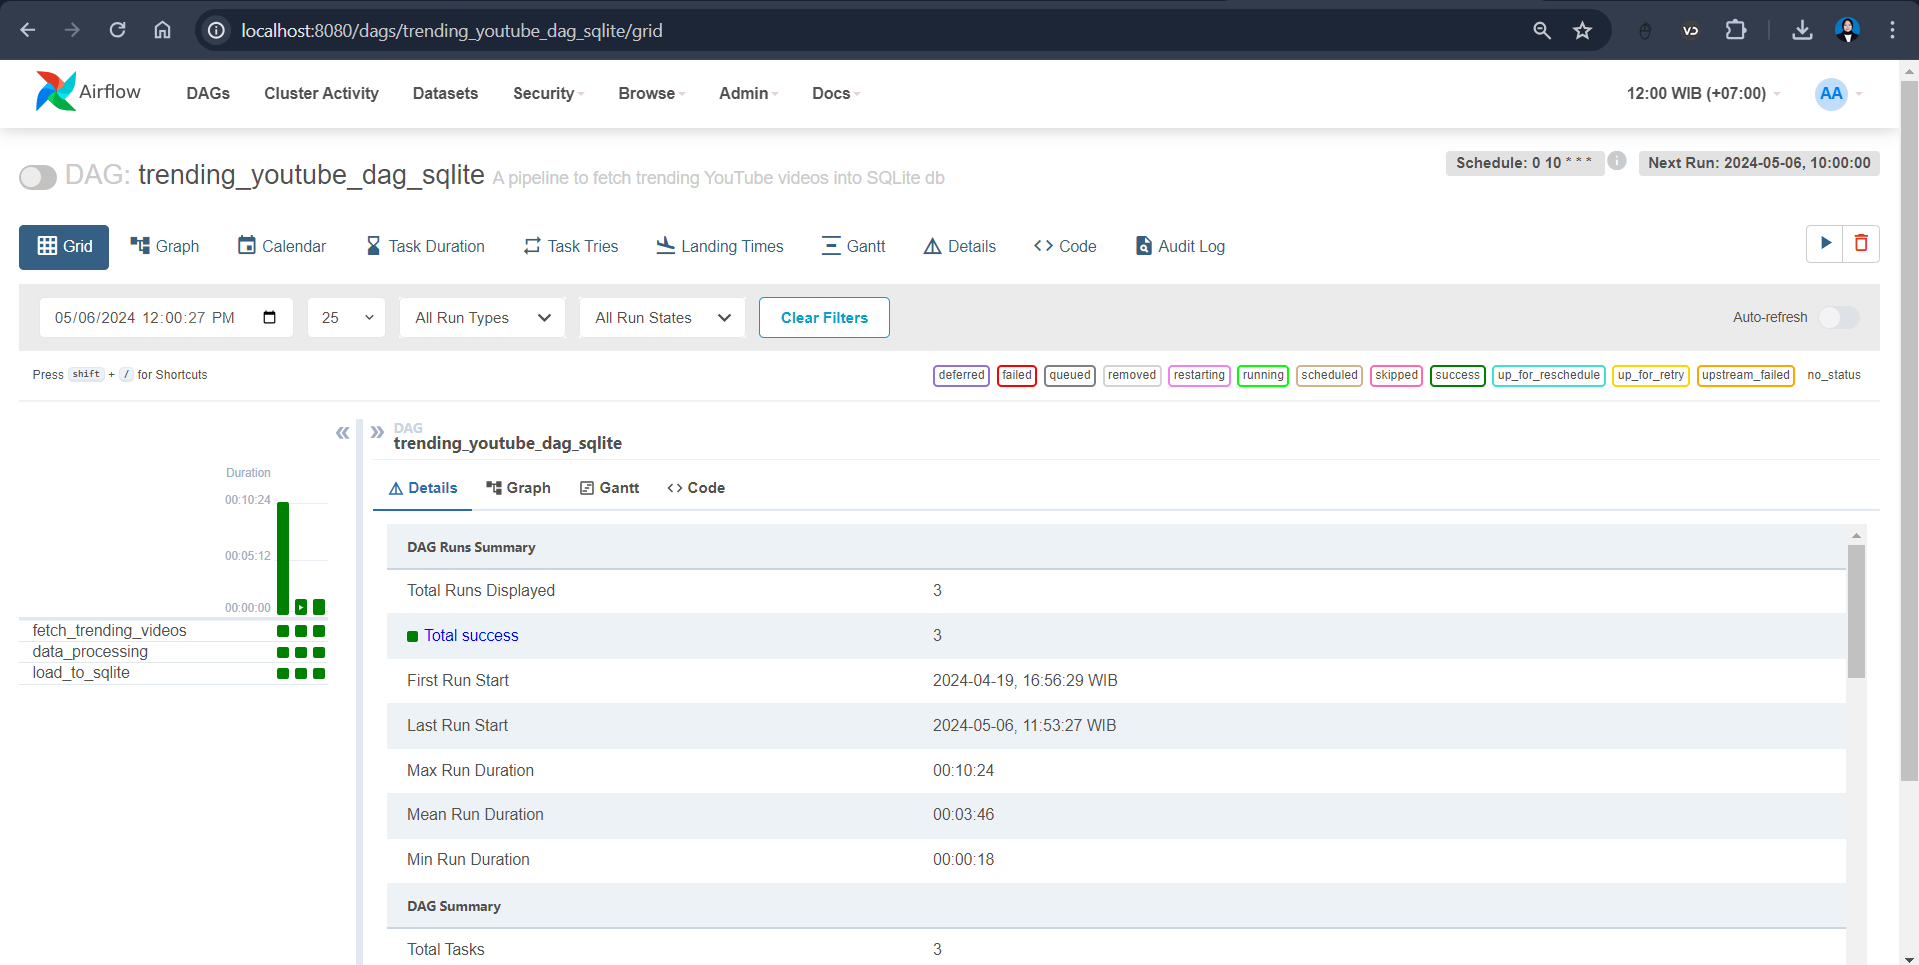

To unpause the DAG, click on the toggle button on the top left corner of the page. The color of the toggle background should change from grey to blue. To check when the next DAG run will be, hover to the light gray box containing Next Run: .... A dark gray box will appear showing details such as `Run After, Next Run` and Date Interval. 

> In the case below, the dark gray box indicates that the next DAG run is scheduled to occur in a day.

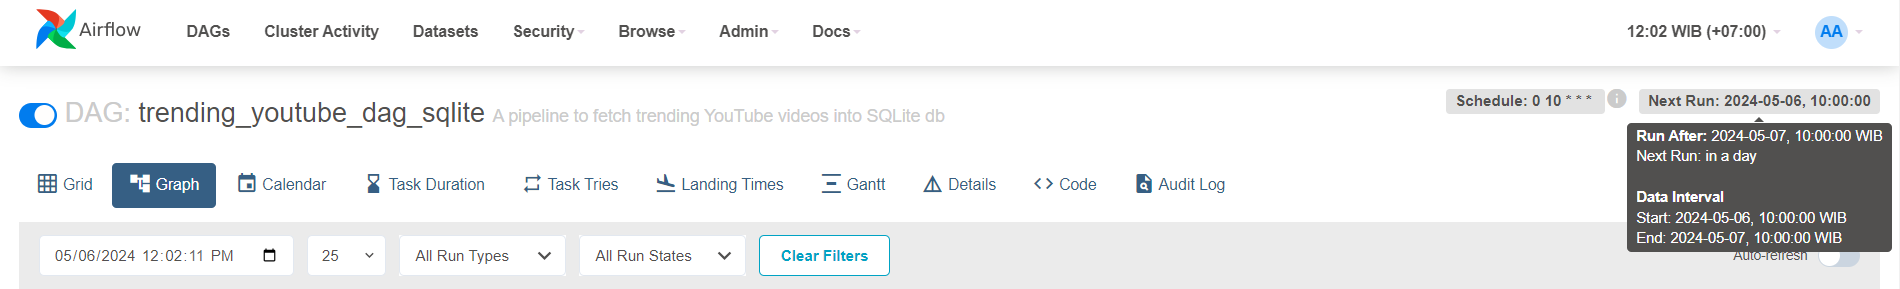

If you wish to visualize the dependencies between the tasks, you can click on the Graph tab. The screenshot below shows the dependencies between the tasks in our DAG.

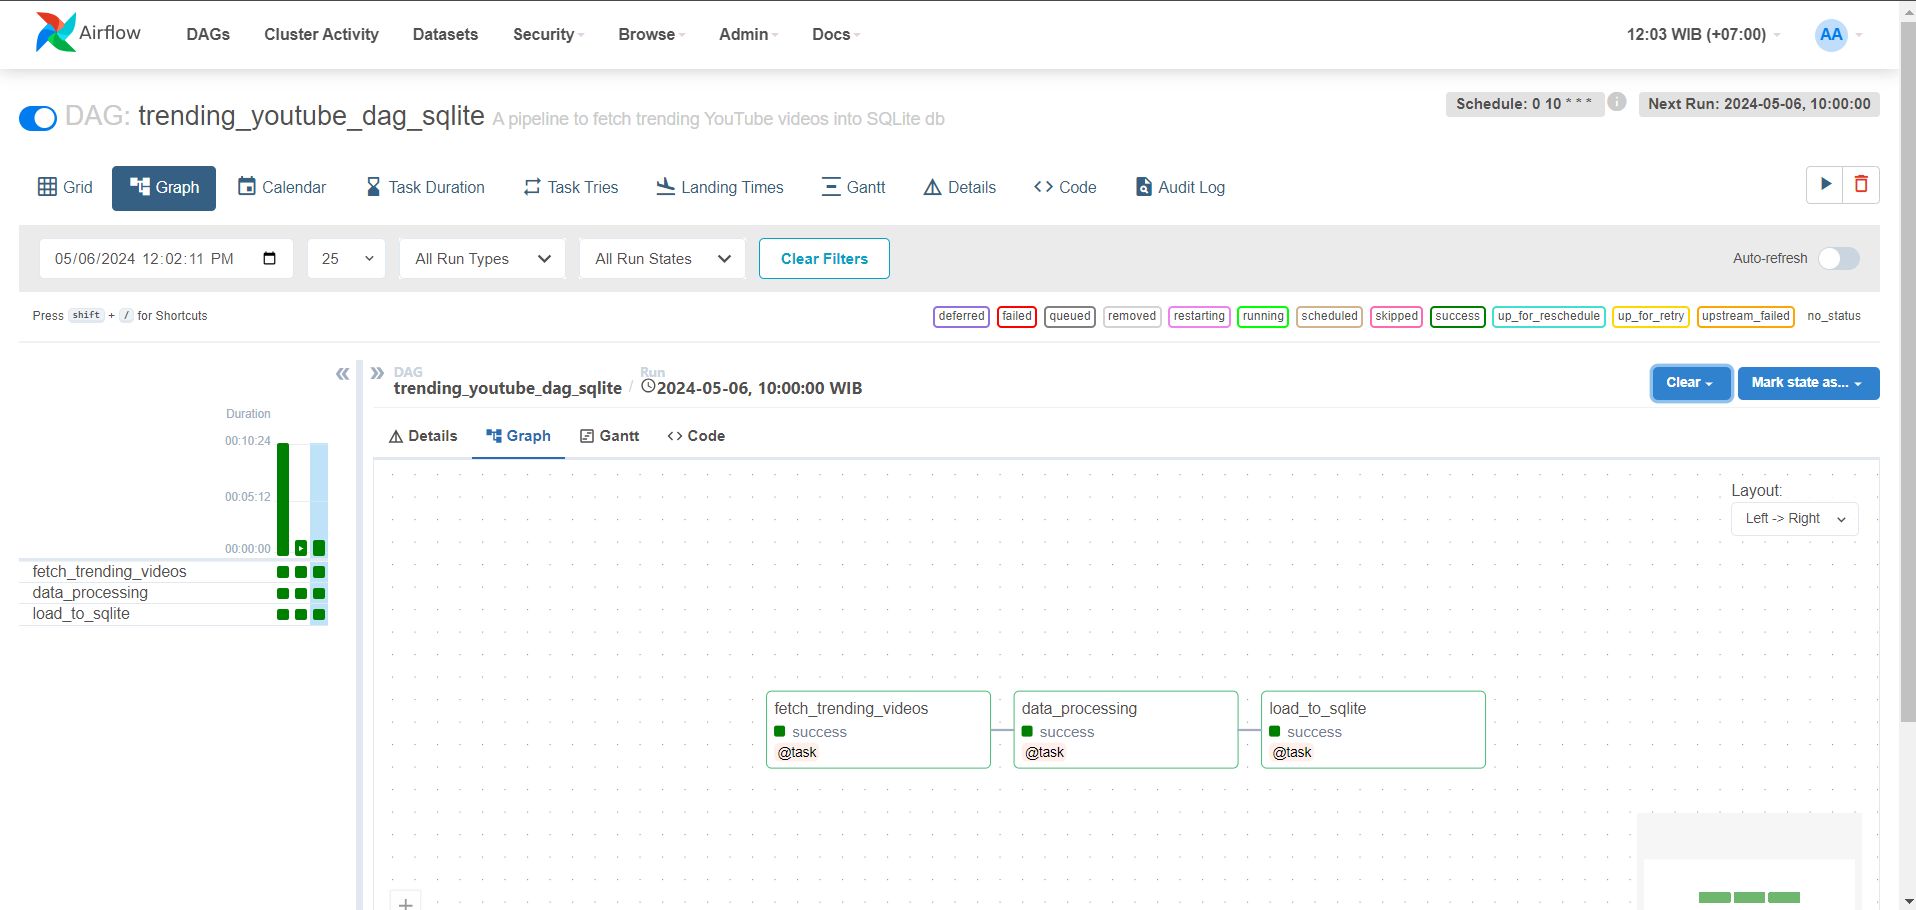

After the DAG has been executed, we can can monitor the status of the DAG run and individual tasks to ensure everything ran as expected. The screenshot below shows the status of our first DAG run and the corresponding tasks. In the Airflow UI, successful tasks are denoted by green boxes, while any failed tasks will be denoted by red boxes. 

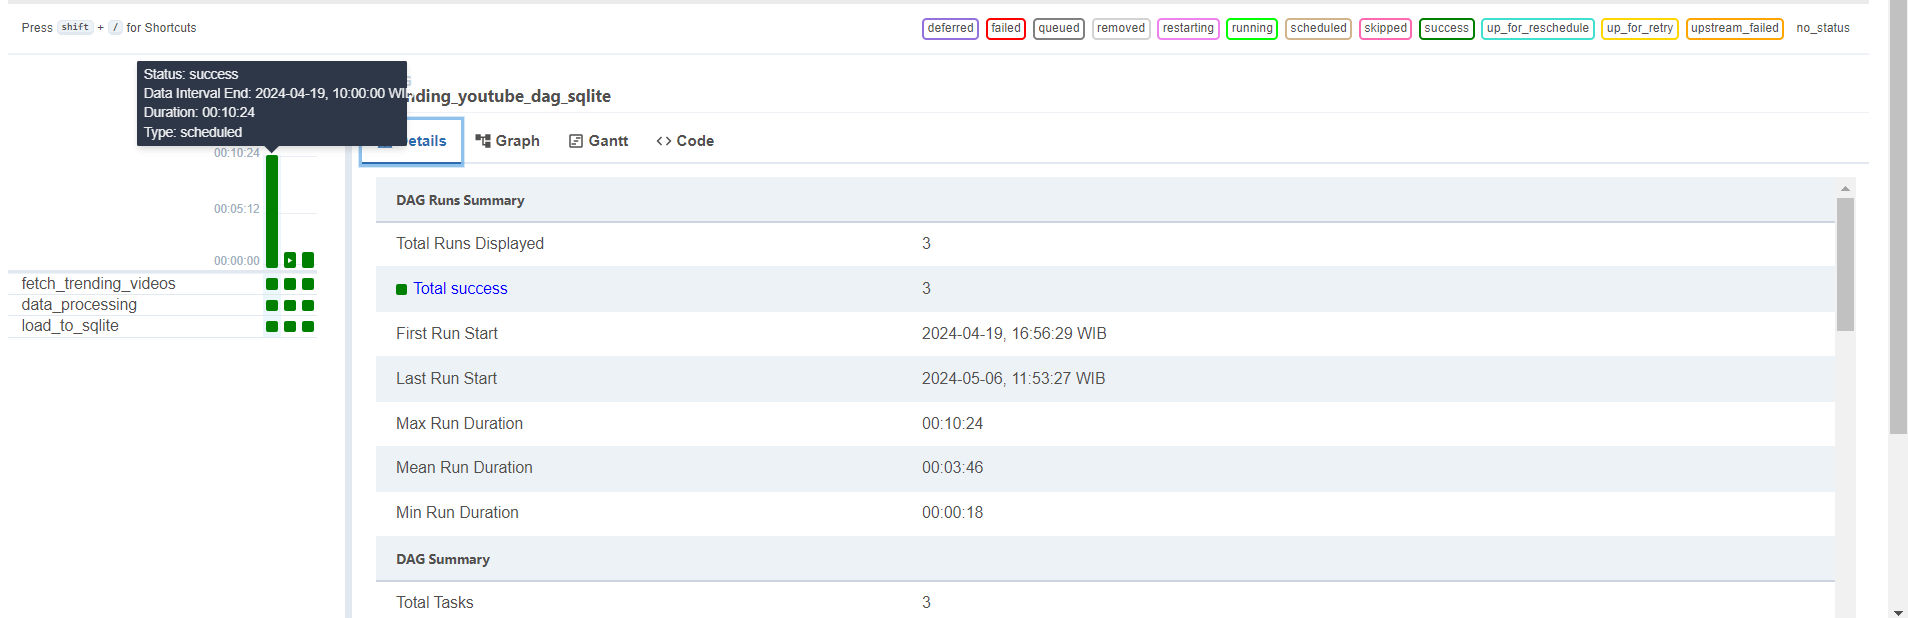

Additionally, hovering over each task provides additional information such as the execution date and duration, allowing us to analyze the performance of our DAG. If you are interested to see the logs of each task, simply click on the respective task box and select the `Logs` option.

---

Notice that earlier we have only installed the dependecies in the youtube_airflow_env virtual environment on our local machine. 

You might be curious how the DAG can run successfully within the Docker environment even though we have not installed any of the dependencies inside the Docker containers. Well, this is because the Docker containers (which are created from the docker-compose.yaml file provided by Airflow) come with a set of pre-installed Python libraries by default, which happen to include all of our required dependencies. 

We can verify this by opening the terminal within the airflow-worker-1 container and checking if our dependencies are installed using the command below.

```
$ container_id=$(docker ps --filter name=airflow-worker-1 --format "{{.ID}}")
$ docker exec -it $container_id bash
$ pip list
```